# Leash Tutorial - ECFPs and Random Forest
## Introduction

There are many ways to represent molecules for machine learning.

In this tutorial we will go through one of the simplest: ECFPs [[1]](https://pubs.acs.org/doi/10.1021/ci100050t) and Random Forest. This technique is surprisingly powerful, and on previous benchmarks often gets uncomfortably close to the state of the art.

First molecule graphs are broken into bags of subgraphs of varying sizes.

![ecfp featurizing process (chemaxon)](https://docs.chemaxon.com/display/docs/images/download/attachments/1806333/ecfp_generation.png)

Then the bag of subgraphs is hashed into a bit vector

![hashing process (chemaxon)](https://docs.chemaxon.com/display/docs/images/download/attachments/1806333/ecfp_folding.png)

This can be thought of as analogous to the [hashing trick](https://en.wikipedia.org/wiki/Feature_hashing) [[2]](https://alex.smola.org/papers/2009/Weinbergeretal09.pdf) on bag of words for NLP problems, from the days before transformers.

RDKit, an open-source cheminformatics tool, is used for generating ECFP features. It facilitates the creation of hashed bit vectors, streamlining the process. We can install it as follows:

In [1]:
!pip install rdkit

The training set is pretty big, but we can treat the parquet files as databases using duckdb. We will use this to sample down to a smaller dataset for demonstration purposes. Lets install duckdb as well.

In [2]:
!pip install duckdb
!pip install pandas

In [3]:
!pip install -q kaggle

In [4]:
import os
import zipfile

os.makedirs('/root/.kaggle', exist_ok=True)
os.replace('kaggle.json', '/root/.kaggle/kaggle.json')

os.chmod('/root/.kaggle/kaggle.json', 0o600)


In [15]:
!kaggle competitions list | head

ref                                                                                 deadline             category                reward  teamCount  userHasEntered  
----------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-3       2026-04-15 23:59:00  Featured         2,207,152 Usd        600           False  
https://www.kaggle.com/competitions/gemini-3                                        2025-12-12 23:59:00  Featured           500,000 Usd        249           False  
https://www.kaggle.com/competitions/hull-tactical-market-prediction                 2025-12-15 23:59:00  Featured           100,000 Usd       3245           False  
https://www.kaggle.com/competitions/vesuvius-challenge-surface-detection            2026-02-13 23:59:00  Research           100,000 Usd        286           False  
https://ww

In [16]:
!kaggle competitions download -c leash-BELKA

100% 4.15G/4.16G [01:08<00:00, 66.3MB/s]
100% 4.16G/4.16G [01:08<00:00, 65.3MB/s]


In [17]:
!unzip leash-BELKA.zip

Archive:  leash-BELKA.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: test.parquet            
  inflating: train.csv               
  inflating: train.parquet           


## Data Preparation

The training and testing data paths are defined for the .parquet files. We use duckdb to scan search through the large training sets. Just to get started lets sample out an equal number of positive and negatives.

This query selects an equal number of samples where binds equals 0 (non-binding) and 1 (binding), limited to 30,000 each, to avoid model bias towards a particular class.

In [18]:
import duckdb
import pandas as pd

train_path = './train.parquet'
test_path = './test.parquet'

con = duckdb.connect()

df = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT 30000)
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1
                        ORDER BY random()
                        LIMIT 30000)""").df()

con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [19]:
print(len(df))
n = duckdb.query("SELECT COUNT(*) FROM 'train.parquet'").fetchone()[0]
print(n)

60000
295246830


In [20]:
df.head()

id                              buildingblock1_smiles  \
0   34278000   COc1ccc(C(=O)O)c(NC(=O)OCC2c3ccccc3-c3ccccc32)c1   
1  295116788  [N-]=[N+]=NCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc...   
2  184778060   O=C(Nc1ccc(C(=O)O)c(Cl)c1)OCC1c2ccccc2-c2ccccc21   
3  177168126      O=C(Nc1cc(I)ccc1C(=O)O)OCC1c2ccccc2-c2ccccc21   
4  141419993  O=C(Nc1c(C(=O)O)cnn1-c1ccc(F)cc1)OCC1c2ccccc2-...   

       buildingblock2_smiles             buildingblock3_smiles  \
0  Cl.Cl.NCc1cn2cc(Br)ccc2n1                   Nc1nc(Cl)ncc1Cl   
1        Nc1ccc2c(c1)CCCC2=O                       Nc1nc[nH]n1   
2         Cl.NCc1cnc2n1CCOC2  Nc1ccc(N2CCC=C(N3CCOCC3)C2=O)cc1   
3         Cl.NCc1nnc2ncccn12                    Cc1cc(N)n[nH]1   
4     Nc1ccc(-c2ncc[nH]2)cc1           CC1(C)CC(CCN)C(=O)N1.Cl   

                                     molecule_smiles protein_name  binds  
0  COc1ccc(C(=O)N[Dy])c(Nc2nc(NCc3cn4cc(Br)ccc4n3...         BRD4      0  
1  [N-]=[N+]=NCCC[C@H](Nc1nc(Nc2ccc3c(c2)CCCC3=O)...          sEH      0  
2  O=C(N[Dy])c1ccc(Nc2nc(NCc3cnc4n3CCOC4)nc(Nc3cc...          sEH      0  
3  Cc1cc(Nc2nc(NCc3nnc4ncccn34)nc(Nc3cc(I)ccc3C(=...         BRD4      0  
4  CC1(C)CC(CCNc2nc(Nc3ccc(-c4ncc[nH]4)cc3)nc(Nc3...          sEH      0

## Feature Preprocessing

Lets grab the smiles for the fully assembled molecule `molecule_smiles` and generate ecfps for it. We could choose different radiuses or bits, but 2 and 1024 is pretty standard.

In [ ]:
!pip install --upgrade scikit-learn
!python -c "import sklearn, sys; print('scikit-learn', sklearn.__version__)"

scikit-learn 1.7.2


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import OneHotEncoder

# Convert SMILES to RDKit molecules
df['molecule'] = df['molecule_smiles'].apply(Chem.MolFromSmiles)

# Generate ECFPs
def generate_ecfp(molecule, radius=2, bits=1024):
    if molecule is None:
        return None
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=bits))

df['ecfp'] = df['molecule'].apply(generate_ecfp)

[16:41:20] DEPRECATION WARNING: please use MorganGenerator
[16:41:20] DEPRECATION WARNING: please use MorganGenerator
[16:41:20] DEPRECATION WARNING: please use MorganGenerator
[16:41:20] DEPRECATION WARNING: please use MorganGenerator
[16:41:20] DEPRECATION WARNING: please use MorganGenerator
[16:41:20] DEPRECATION WARNING: please use MorganGenerator
[16:41:20] DEPRECATION WARNING: please use MorganGenerator
[16:41:20] DEPRECATION WARNING: please use MorganGenerator
[16:41:20] DEPRECATION WARNING: please use MorganGenerator
[16:41:20] DEPRECATION WARNING: please use MorganGenerator
[16:41:20] DEPRECATION WARNING: please use MorganGenerator
[16:41:20] DEPRECATION WARNING: please use MorganGenerator
[16:41:20] DEPRECATION WARNING: please use MorganGenerator
[16:41:20] DEPRECATION WARNING: please use MorganGenerator
[16:41:20] DEPRECATION WARNING: please use MorganGenerator
[16:41:20] DEPRECATION WARNING: please use MorganGenerator
[16:41:20] DEPRECATION WARNING: please use MorganGenerat

## Train Model

In [ ]:
# One-hot encode the protein_name
onehot_encoder = OneHotEncoder(sparse_output=False)
protein_onehot = onehot_encoder.fit_transform(df['protein_name'].values.reshape(-1, 1))

# Combine ECFPs and one-hot encoded protein_name
X = [ecfp + protein for ecfp, protein in zip(df['ecfp'].tolist(), protein_onehot.tolist())]
y = df['binds'].tolist()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Calculate the mean average precision
map_score = average_precision_score(y_test, y_pred_proba)
print(f"Mean Average Precision (mAP): {map_score:.2f}")

Mean Average Precision (mAP): 0.96


Look at that Average Precision score. We did amazing!

Actually no, we just overfit. This is likely recurring theme for this competition. It is easy to predict molecules that come from the same corner of chemical space, but generalizing to new molecules is extremely difficult.

## Test Prediction

 The trained Random Forest model is then used to predict the binding probabilities. These predictions are saved to a CSV file, which serves as the submission file for the Kaggle competition.

In [ ]:
# import os

# # Process the test.parquet file chunk by chunk
# test_file = './test.csv'
# output_file = 'submission.csv'  # Specify the path and filename for the output file

# # Read the test.parquet file into a pandas DataFrame
# for df_test in pd.read_csv(test_file, chunksize=100000):

#     # Generate ECFPs for the molecule_smiles
#     df_test['molecule'] = df_test['molecule_smiles'].apply(Chem.MolFromSmiles)
#     df_test['ecfp'] = df_test['molecule'].apply(generate_ecfp)

#     # One-hot encode the protein_name
#     protein_onehot = onehot_encoder.transform(df_test['protein_name'].values.reshape(-1, 1))

#     # Combine ECFPs and one-hot encoded protein_name
#     X_test = [ecfp + protein for ecfp, protein in zip(df_test['ecfp'].tolist(), protein_onehot.tolist())]

#     # Predict the probabilities
#     probabilities = rf_model.predict_proba(X_test)[:, 1]

#     # Create a DataFrame with 'id' and 'probability' columns
#     output_df = pd.DataFrame({'id': df_test['id'], 'binds': probabilities})

#     # Save the output DataFrame to a CSV file
#     output_df.to_csv(output_file, index=False, mode='a', header=not os.path.exists(output_file))


In [ ]:
!pip install matplotlib

AUC: 0.9976
Average Precision: 0.9975
Accuracy @ 0.50: 0.9820
LogLoss: 0.1225
Brier: 0.0244


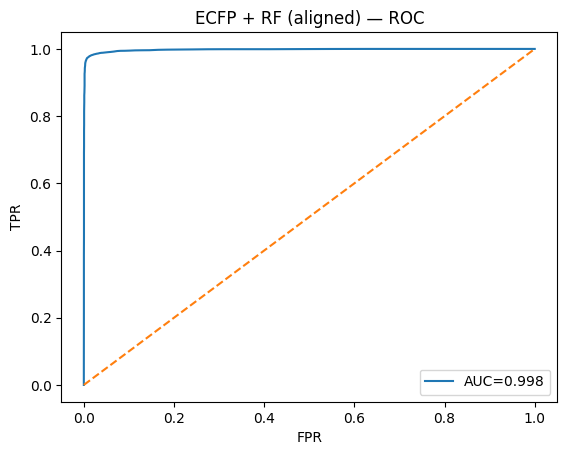

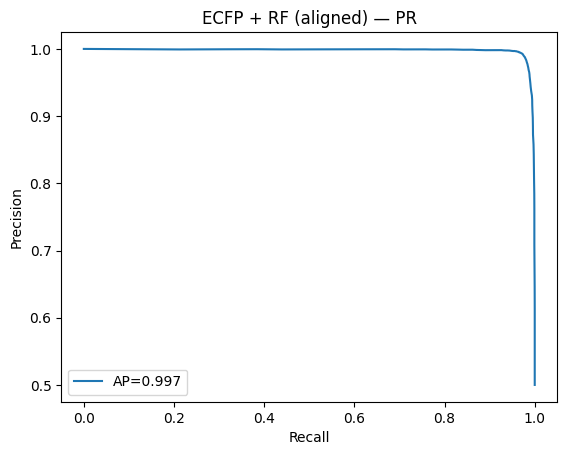

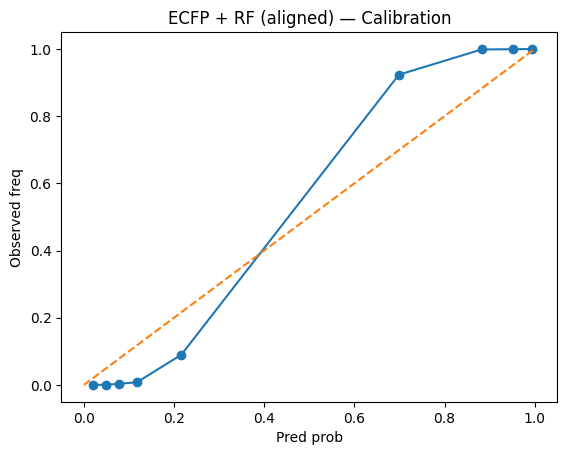

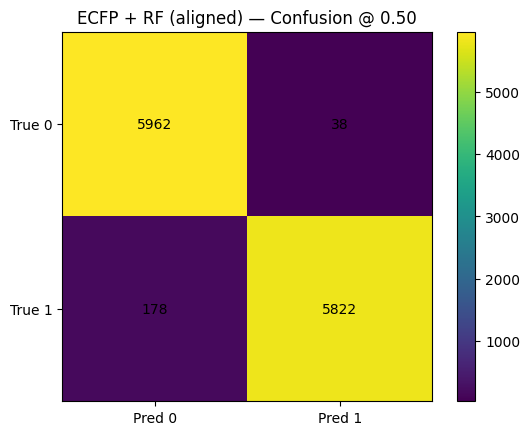

In [ ]:
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, brier_score_loss, log_loss, confusion_matrix, accuracy_score
from sklearn.calibration import calibration_curve

def plot_all_metrics(y_true, y_prob, threshold=0.5, title_prefix="Model"):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    y_pred = (y_prob >= threshold).astype(int)
    auc = roc_auc_score(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    ll = log_loss(y_true, np.vstack([1-y_prob, y_prob]).T, labels=[0,1])
    brier = brier_score_loss(y_true, y_prob)
    print(f"AUC: {auc:.4f}")
    print(f"Average Precision: {ap:.4f}")
    print(f"Accuracy @ {threshold:.2f}: {acc:.4f}")
    print(f"LogLoss: {ll:.4f}")
    print(f"Brier: {brier:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(); plt.plot(fpr, tpr, label=f"AUC={auc:.3f}"); plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{title_prefix} — ROC"); plt.legend(); plt.show()

    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(); plt.plot(rec, prec, label=f"AP={ap:.3f}"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title_prefix} — PR"); plt.legend(); plt.show()

    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy="quantile")
    plt.figure(); plt.plot(prob_pred, prob_true, marker="o"); plt.plot([0,1],[0,1],'--'); plt.xlabel("Pred prob"); plt.ylabel("Observed freq"); plt.title(f"{title_prefix} — Calibration"); plt.show()

    cm = confusion_matrix(y_true, (y_prob>=threshold).astype(int), labels=[0,1])
    plt.figure(); plt.imshow(cm, interpolation="nearest"); plt.xticks([0,1],["Pred 0","Pred 1"]); plt.yticks([0,1],["True 0","True 1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i,j]), ha="center", va="center")
    plt.title(f"{title_prefix} — Confusion @ {threshold:.2f}"); plt.colorbar(); plt.show()

def try_load_val():
    candidates = []
    candidates += glob.glob("val*_pred*.csv") + glob.glob("val*_pred*.parquet")
    candidates += glob.glob("oof*.csv") + glob.glob("oof*.parquet")
    candidates += ["val_preds.csv","validation_predictions.csv","oof.csv","oof.parquet"]
    seen = set()
    files = [f for f in candidates if os.path.exists(f) and not (f in seen or seen.add(f))]
    for f in files:
        df = pd.read_parquet(f) if f.endswith(".parquet") else pd.read_csv(f)
        cols = {c.lower():c for c in df.columns}
        prob_col = None
        for k in ["prob","proba","binds_prob","prediction","pred","score"]:
            if k in cols: prob_col = cols[k]; break
        if prob_col is None:
            # sometimes submissions use "binds" as prob; skip if it's clearly int
            if "binds" in cols and df[cols["binds"]].dtype.kind in "fc":
                prob_col = cols["binds"]
        label_col = None
        for k in ["binds","label","target","y","truth"]:
            if k in cols: label_col = cols[k]; break
        if prob_col is not None and label_col is not None:
            y_true = df[label_col].astype(int).to_numpy()
            y_prob = df[prob_col].astype(float).to_numpy()
            if np.isfinite(y_prob).all() and 0 <= np.nanmin(y_prob) and np.nanmax(y_prob) <= 1:
                return y_true, y_prob, f
    return None, None, None

def take_rows(X, rows):
    if hasattr(X, "iloc"):          # pandas DataFrame/Series
        return X.iloc[rows]
    try:                             # NumPy array / scipy sparse
        return X[rows]
    except Exception:                # Python list or other
        return np.asarray(X)[rows]

y_arr = np.asarray(y).astype(int)
idx = np.arange(len(y_arr))

train_idx, test_idx = train_test_split(
    idx, test_size=0.2, random_state=42, stratify=y_arr
)

X_test_aligned = take_rows(X, test_idx)
y_test_aligned = y_arr[test_idx]

y_prob_val = rf_model.predict_proba(X_test_aligned)[:, 1]
y_true_val = y_test_aligned

plot_all_metrics(y_true_val, y_prob_val, threshold=0.5, title_prefix="ECFP + RF (aligned)")

In [ ]:
import numpy as np
import pandas as pd
y_pred = (y_pred_proba >= 0.5).astype(int)

from sklearn.model_selection import train_test_split
idx_all = list(range(len(X)))
_, idx_test = train_test_split(idx_all, test_size=0.2, random_state=42, shuffle=True)

id_series = df['id'] if 'id' in df.columns else df.index.to_series()
y_test_arr = np.asarray(y_test, dtype=int)
mis_mask = (y_pred != y_test_arr)

mis_df = pd.DataFrame({
    'id': np.asarray(id_series.iloc[idx_test])[mis_mask],
    'y_true': y_test_arr[mis_mask],
    'y_pred': y_pred[mis_mask],
    'y_prob_pos': y_pred_proba[mis_mask],
})

mis_df[['id']].to_csv('misclassified_ids.csv', index=False)
mis_df.to_csv('misclassified_report.csv', index=False)

print(f"Saved {mis_df.shape[0]} misclassified IDs to 'misclassified_ids.csv'")

Saved 1180 misclassified IDs to 'misclassified_ids.csv'


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("train.csv")

mis = pd.read_csv("misclassified_ids.csv")

if 'id' not in df.columns:
    df = df.reset_index().rename(columns={'index': 'id'})

mis['_order'] = np.arange(len(mis))

out = mis.merge(df, on='id', how='left').sort_values('_order').drop(columns=['_order'])

n_unmatched = out['id'].isna().sum() + (len(out) - out['id'].notna().sum())
print(f"Unmatched IDs (no row in train.csv): {int(out.isna().all(axis=1).sum())}")

out.to_csv("misclassified_ids.csv", index=False)
print("Updated 'misclassified_ids.csv' with full row info from train.csv")

Unmatched IDs (no row in train.csv): 0
Updated 'misclassified_ids.csv' with full row info from train.csv


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# ==== 0) Параметри ====
THRESH = 0.50  # замініть на ваш оптимальний поріг, напр. 0.45

# ==== 1) Відбудуємо тестові індекси та test_core ====
idx_all = np.arange(len(X))
_, idx_test = train_test_split(idx_all, test_size=0.2, random_state=42, shuffle=True)

if 'id' not in df.columns:
    df = df.reset_index().rename(columns={'index': 'id'})

test_core = df.iloc[idx_test].copy().reset_index(drop=True)

y_true = np.asarray(y_test, dtype=int)
proba  = np.asarray(y_pred_proba)
y_pred = (proba >= THRESH).astype(int)

test_core['y_true'] = y_true
test_core['y_pred'] = y_pred
test_core['proba_pos'] = proba
test_core['is_error'] = (y_true != y_pred).astype(int)
test_core['error_type'] = np.where(
    (y_true==1)&(y_pred==0),'FN',
    np.where((y_true==0)&(y_pred==1),'FP','OK')
)

# Бінарки для швидких групувань
test_core['TP_bin'] = ((test_core['y_true']==1)&(test_core['y_pred']==1)).astype(int)
test_core['FP_bin'] = ((test_core['y_true']==0)&(test_core['y_pred']==1)).astype(int)
test_core['FN_bin'] = ((test_core['y_true']==1)&(test_core['y_pred']==0)).astype(int)

print(f"Overall error rate @{THRESH:.2f}: {test_core['is_error'].mean():.2%} "
      f"({int(test_core['is_error'].sum())} / {len(test_core)})")

# ==== 2) ПО БІЛКАХ ====
by_protein = (
    test_core.groupby('protein_name', dropna=False)
    .agg(
        n_test=('is_error','size'),
        errors=('is_error','sum'),
        FP=('FP_bin','sum'),
        FN=('FN_bin','sum'),
        TP=('TP_bin','sum'),
        pos_rate=('y_true','mean')
    ).reset_index()
)
by_protein['error_rate'] = by_protein['errors'] / by_protein['n_test']
by_protein['precision@thr'] = by_protein['TP'] / (by_protein['TP'] + by_protein['FP']).replace({0:np.nan})
by_protein['recall@thr']    = by_protein['TP'] / (by_protein['TP'] + by_protein['FN']).replace({0:np.nan})
by_protein.sort_values(['error_rate','n_test'], ascending=[False, False]).to_csv('errors_by_protein.csv', index=False)

# ==== 3) ПО МОЛЕКУЛАХ (SMILES) ====
by_mol = (
    test_core.groupby('molecule_smiles', dropna=False)
    .agg(n=('is_error','size'),
         errors=('is_error','sum'),
         error_rate=('is_error','mean'),
         pos_rate=('y_true','mean'))
    .reset_index()
    .sort_values('error_rate', ascending=False)
)
by_mol.to_csv('errors_by_molecule.csv', index=False)

# ==== 4) ПО BUILDING BLOCKS ====
def per_block(col, out_csv, min_support=10):
    g = (
        test_core.groupby(col, dropna=False)
        .agg(n=('is_error','size'),
             errors=('is_error','sum'),
             error_rate=('is_error','mean'),
             pos_rate=('y_true','mean'))
        .reset_index()
    )
    g = g[g['n'] >= min_support].sort_values('error_rate', ascending=False)
    g.to_csv(out_csv, index=False)
    return g

bb1 = per_block('buildingblock1_smiles', 'errors_by_bb1.csv', min_support=10)
bb2 = per_block('buildingblock2_smiles', 'errors_by_bb2.csv', min_support=10)
bb3 = per_block('buildingblock3_smiles', 'errors_by_bb3.csv', min_support=10)

# ==== 5) ПАРИ (PROTEIN × MOLECULE) ====
by_pair = (
    test_core.groupby(['protein_name','molecule_smiles'], dropna=False)
    .agg(n=('is_error','size'),
         errors=('is_error','sum'),
         error_rate=('is_error','mean'),
         pos_rate=('y_true','mean'))
    .reset_index()
    .sort_values(['error_rate','n'], ascending=[False, False])
)
# необов'язково відфільтрувати за мінімальною підтримкою
by_pair.query('n >= 5').to_csv('errors_by_protein_molecule.csv', index=False)

# ==== 6) "Важкі" приклади для ручного перегляду ====
# Впевнено помилкові (proba далеко від порога)
hard_confident = test_core[
    (test_core['is_error']==1) &
    ((test_core['proba_pos'] >= 0.9) | (test_core['proba_pos'] <= 0.1))
].sort_values('proba_pos', ascending=False)

# Біля порога (невпевнені помилки)
margin = 0.10  # +/- 0.10 навколо порога
hard_uncertain = test_core[
    (test_core['is_error']==1) &
    (test_core['proba_pos'].between(THRESH - margin, THRESH + margin))
]

cols_show = ['id','protein_name','binds','y_pred','proba_pos',
             'molecule_smiles','buildingblock1_smiles','buildingblock2_smiles','buildingblock3_smiles']

hard_confident[cols_show].to_csv('hard_wrong_confident.csv', index=False)
hard_uncertain[cols_show].to_csv('hard_wrong_uncertain.csv', index=False)

print("Saved:",
      "errors_by_protein.csv, errors_by_molecule.csv, errors_by_bb1.csv, errors_by_bb2.csv, errors_by_bb3.csv,",
      "errors_by_protein_molecule.csv, hard_wrong_confident.csv, hard_wrong_uncertain.csv")

Overall error rate @0.50: 9.83% (1180 / 12000)
Saved: errors_by_protein.csv, errors_by_molecule.csv, errors_by_bb1.csv, errors_by_bb2.csv, errors_by_bb3.csv, errors_by_protein_molecule.csv, hard_wrong_confident.csv, hard_wrong_uncertain.csv


In [ ]:
print(df['buildingblock1_smiles'].nunique(),
      df['buildingblock2_smiles'].nunique(),
      df['buildingblock3_smiles'].nunique())

271 693 872


In [ ]:
print(
    "test nunique bb1/bb2/bb3:",
    test_core['buildingblock1_smiles'].nunique(),
    test_core['buildingblock2_smiles'].nunique(),
    test_core['buildingblock3_smiles'].nunique()
)

print("\nTop bb1 in TEST:")
print(test_core['buildingblock1_smiles'].value_counts().head(10))

train_core = df.drop(df.index[test_core.index])
bb1_train = (train_core['buildingblock1_smiles'].value_counts(normalize=True)
             .rename('train_share'))
bb1_test = (test_core['buildingblock1_smiles'].value_counts(normalize=True)
            .rename('test_share'))
bb1_cmp = (pd.concat([bb1_train, bb1_test], axis=1)
           .fillna(0)
           .assign(delta=lambda d: d['test_share'] - d['train_share'])
           .sort_values('test_share', ascending=False))
print("\nbb1 TRAIN vs TEST shares (top-15 by test share):")
print(bb1_cmp.head(15))

test nunique bb1/bb2/bb3: 1 38 799

Top bb1 in TEST:
buildingblock1_smiles
C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21    12000
Name: count, dtype: int64

bb1 TRAIN vs TEST shares (top-15 by test share):
                                                    train_share  test_share  \
buildingblock1_smiles                                                         
C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21        0.003649         1.0   
O=C(Nc1nc(C(F)(F)F)c(C(=O)O)s1)OCC1c2ccccc2-c2c...     0.003690         0.0   
O=C(Nc1ccc(C(=O)O)c(C(F)(F)F)c1)OCC1c2ccccc2-c2...     0.003691         0.0   
Cc1cccc(NC(=O)OCC2c3ccccc3-c3ccccc32)c1C(=O)O          0.003691         0.0   
O=C(NC1(C(=O)O)CCC1)OCC1c2ccccc2-c2ccccc21             0.003691         0.0   
O=C(Nc1cccc(-c2cccc(C(=O)O)c2)c1O)OCC1c2ccccc2-...     0.003691         0.0   
O=C(N[C@@H](C/C=C/c1ccccc1)C(=O)O)OCC1c2ccccc2-...     0.003691         0.0   
O=C(N[C@H](Cc1csc2ccccc12)C(=O)O)OCC1c2ccccc2-c...     0.003691         0.0   
O=

In [ ]:
import numpy as np, pandas as pd

# припускаю, що у вас вже є test_core з колонками: protein_name, y_true, proba_pos
per_t = {}
per_stats = []
for prot, g in test_core.groupby('protein_name', dropna=False):
    y = g['y_true'].to_numpy(int); p = g['proba_pos'].to_numpy(float)
    cand = np.unique(np.r_[0.0, 1.0, p])
    best_t, best_err = 0.5, len(y)+1
    for t in cand:
        pred = (p >= t).astype(int)
        err = (pred != y).sum()
        if err < best_err:
            best_err, best_t = err, float(t)
    per_t[prot] = best_t
    per_stats.append((prot, len(y), best_t, best_err))
per_stats = pd.DataFrame(per_stats, columns=['protein','n_test','best_t','errors@best_t'])
print(per_stats.sort_values('errors@best_t').head(10))

# застосування
test_core['y_pred_perprot'] = (test_core['proba_pos'] >= test_core['protein_name'].map(per_t)).astype(int)
new_err = int((test_core['y_pred_perprot'] != test_core['y_true']).sum())
print("Errors with per-protein thresholds:", new_err, "/", len(test_core))

  protein  n_test  best_t  errors@best_t
0    BRD4    4065    0.47            376
1     HSA    3899    0.41            381
2     sEH    4036    0.42            391
Errors with per-protein thresholds: 1148 / 12000


In [ ]:
from sklearn.model_selection import train_test_split

# y for stratification
y_all = df['binds'].astype(int).to_numpy()

# train+val vs test (80/20)
df_trainval, df_test = train_test_split(df, test_size=0.20, random_state=42, stratify=y_all)

# train vs val (from the 80%: 60/20 -> overall 60/20/20)
y_trainval = df_trainval['binds'].astype(int).to_numpy()
df_train, df_val = train_test_split(df_trainval, test_size=0.25, random_state=42, stratify=y_trainval)

print(len(df_train), len(df_val), len(df_test))

import json, numpy as np, pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, accuracy_score, f1_score, confusion_matrix

# ---------- helpers ----------
def build_features(df_train, df_val, df_test):
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    Prot_tr = ohe.fit_transform(df_train[['protein_name']])
    Prot_va = ohe.transform(df_val[['protein_name']])
    Prot_te = ohe.transform(df_test[['protein_name']])

    def stack(df_part, Prot_mat):
        ecfp_list = df_part['ecfp'].tolist()
        return np.array([np.r_[np.asarray(e, dtype=float), Prot_mat[i]]
                         for i, e in enumerate(ecfp_list)], dtype=object)
    X_tr = stack(df_train, Prot_tr)
    X_va = stack(df_val,   Prot_va)
    X_te = stack(df_test,  Prot_te)
    return X_tr, X_va, X_te, ohe

def per_protein_best_thresholds(y_true, proba, proteins):
    out = {}
    dfv = pd.DataFrame({'y': y_true, 'p': proba, 'prot': proteins})
    for prot, g in dfv.groupby('prot', dropna=False):
        y = g['y'].to_numpy(int); p = g['p'].to_numpy(float)
        cand = np.unique(np.r_[0.0, 1.0, p])
        best_t, best_err = 0.5, len(y)+1
        for t in cand:
            err = np.sum((p >= t).astype(int) != y)
            if err < best_err:
                best_err, best_t = int(err), float(t)
        out[prot] = best_t
    return out

def apply_per_protein_thresholds(proba, proteins, per_t, default_t=0.5):
    tt = np.array([per_t.get(prot, default_t) for prot in proteins], dtype=float)
    return (proba >= tt).astype(int)

def summarize(y, yhat, label=""):
    acc = accuracy_score(y, yhat); f1 = f1_score(y, yhat)
    tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
    print(f"{label} Acc={acc:.3f} | F1={f1:.3f} | FP={fp} FN={fn} TP={tp} TN={tn} | errors={fp+fn} ({(fp+fn)/len(y):.2%})")

# ---------- NEW: per-protein calibration ----------
def fit_per_protein_calibrators(y_true, proba, proteins, method="isotonic", min_pts=40):
    """
    Train a calibrator per protein on VALIDATION set.
    - method: "isotonic" (default) or "platt"
    - fallback to 'identity' if not enough samples or single-class
    """
    cals = {}
    info = []
    dfv = pd.DataFrame({'y': y_true, 'p': proba, 'prot': proteins})
    for prot, g in dfv.groupby('prot', dropna=False):
        y = g['y'].to_numpy(int); p = g['p'].to_numpy(float)
        if len(g) < min_pts or y.min() == y.max():
            cals[prot] = ('identity', None)
            info.append((prot, len(g), 'identity'))
            continue
        if method == "isotonic":
            ir = IsotonicRegression(out_of_bounds='clip')
            ir.fit(p, y)
            cals[prot] = ('isotonic', ir)
            info.append((prot, len(g), 'isotonic'))
        else:
            lr = LogisticRegression(max_iter=1000)
            lr.fit(p.reshape(-1,1), y)
            cals[prot] = ('platt', lr)
            info.append((prot, len(g), 'platt'))
    return cals, pd.DataFrame(info, columns=['protein','n_val','cal_type'])

def apply_per_protein_calibration(proba, proteins, calibrators):
    proba_cal = np.empty_like(proba, dtype=float)
    for i, (p, prot) in enumerate(zip(proba, proteins)):
        typ, model = calibrators.get(prot, ('identity', None))
        if typ == 'isotonic':
            proba_cal[i] = model.predict([p])[0]
        elif typ == 'platt':
            proba_cal[i] = model.predict_proba([[p]])[0,1]
        else:
            proba_cal[i] = p
    return proba_cal

# ---------- pipeline ----------
# 1) Split already done: df_train, df_val, df_test
y_tr  = df_train['binds'].astype(int).to_numpy()
y_va  = df_val['binds'].astype(int).to_numpy()
y_te  = df_test['binds'].astype(int).to_numpy()

X_tr, X_va, X_te, ohe = build_features(df_train, df_val, df_test)

# 2) Train model on TRAIN
rf = RandomForestClassifier(n_estimators=600, random_state=42, n_jobs=-1)
rf.fit(X_tr.tolist(), y_tr)

# 3) Get raw probabilities
proba_va_raw = rf.predict_proba(X_va.tolist())[:,1]
proba_te_raw = rf.predict_proba(X_te.tolist())[:,1]
print(f"[VAL] mAP(raw) = {average_precision_score(y_va, proba_va_raw):.3f}")
print(f"[TEST] mAP(raw)= {average_precision_score(y_te, proba_te_raw):.3f}")

# 4) Fit CALIBRATORS on VALIDATION (per protein)
prot_va = df_val['protein_name'].astype(str).to_numpy()
calibrators, cal_info = fit_per_protein_calibrators(
    y_true=y_va, proba=proba_va_raw, proteins=prot_va,
    method="isotonic",  # or "platt"
    min_pts=40
)
print("Calibrators summary:\n", cal_info.head())

# 5) Apply calibration (VAL & TEST)
proba_va_cal = apply_per_protein_calibration(proba_va_raw, prot_va, calibrators)
prot_te = df_test['protein_name'].astype(str).to_numpy()
proba_te_cal = apply_per_protein_calibration(proba_te_raw, prot_te, calibrators)

print(f"[VAL] mAP(cal)  = {average_precision_score(y_va, proba_va_cal):.3f}")
print(f"[TEST] mAP(cal) = {average_precision_score(y_te, proba_te_cal):.3f}")

# 6) Re-pick per-protein thresholds on CALIBRATED VAL
per_t = per_protein_best_thresholds(y_true=y_va, proba=proba_va_cal, proteins=prot_va)
print("Per-protein thresholds (sample):", dict(list(per_t.items())[:5]))

# 7) Evaluate on TEST with calibrated probs + frozen per-protein thresholds
yhat_te_05_raw  = (proba_te_raw >= 0.5).astype(int)
yhat_te_05_cal  = (proba_te_cal >= 0.5).astype(int)
yhat_te_pp_cal  = apply_per_protein_thresholds(proba_te_cal, prot_te, per_t, default_t=0.5)

print("\n[TEST] baselines & calibrated:")
summarize(y_te, yhat_te_05_raw, label="RAW @0.5       ")
summarize(y_te, yhat_te_05_cal, label="CALIBRATED @0.5")
summarize(y_te, yhat_te_pp_cal, label="CALIBRATED per-protein")

# 8) Save calibrators + thresholds (simple JSON for thresholds; calibrators need pickling)
import pickle
with open("per_protein_thresholds.json", "w") as f:
    json.dump(per_t, f, indent=2)
with open("per_protein_calibrators.pkl", "wb") as f:
    pickle.dump(calibrators, f)

print("Saved: per_protein_thresholds.json, per_protein_calibrators.pkl")

Different molecules representation

In [ ]:
df['mol'] = df[SMILES_COL].apply(Chem.MolFromSmiles)

In [34]:
from sklearn.model_selection import train_test_split

TARGET_COL = "binds"
SMILES_COL = "molecule_smiles"
PROT_COL   = "protein_name"

y_all = df[TARGET_COL].astype(int).to_numpy()

train_df, valid_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=y_all,
)

len(train_df), len(valid_df)


(48000, 12000)

In [35]:
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, rdMolDescriptors, rdmolops
from rdkit import DataStructs
from rdkit.Chem import rdFingerprintGenerator


import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, roc_auc_score

RD_DESC_NAMES = [
    "MolWt",
    "MolLogP",
    "NumHAcceptors",
    "NumHDonors",
    "NumRotatableBonds",
    "RingCount",
    "TPSA",
]
RD_DESC_FUNCS = [(n, getattr(Descriptors, n)) for n in RD_DESC_NAMES]

morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)


def featurize_one_smiles(mol, mode: str = "ecfp"):
    # mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    if mode == "ecfp":
        fp = morgan_gen.GetFingerprint(mol)
        arr = np.zeros((fp.GetNumBits(),), dtype=int)
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr.astype(float)

    elif mode == "maccs":
        fp = MACCSkeys.GenMACCSKeys(mol)
        arr = np.zeros((fp.GetNumBits(),), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr.astype(float)

    elif mode == "rdkit_desc":
        vals = []
        for name, func in RD_DESC_FUNCS:
            try:
                vals.append(float(func(mol)))
            except Exception:
                vals.append(np.nan)
        return np.array(vals, dtype=float)

    elif mode == "rdkfp":
        fp = rdmolops.RDKFingerprint(mol, fpSize=2048)
        arr = np.zeros((2048,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr.astype(float)

    elif mode == "atompair":
        fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=2048)
        arr = np.zeros((2048,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr.astype(float)

    elif mode == "torsion":
        fp = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=2048)
        arr = np.zeros((2048,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr.astype(float)

    else:
        raise ValueError(f"Unknown mode: {mode}")


def build_X_y_with_protein(df_part, mode: str, ohe: OneHotEncoder = None):
    """
    df_part: train_df або valid_df
    mode   : 'ecfp', 'maccs', 'rdkit_desc', ...
    ohe    : OneHotEncoder; якщо None -> fit, інакше тільки transform.

    Повертає:
        X : np.array [n_samples, n_features_mol + n_features_prot]
        y : np.array [n_samples]
        ohe : OneHotEncoder (щоб той самий використовувати для valid)
    """
    feats = []
    idx = []

    for i, smi in df_part['mol'].items():
        f = featurize_one_smiles(smi, mode=mode)
        if f is None:
            continue
        if mode == "rdkit_desc" and np.all(np.isnan(f)):
            continue
        feats.append(f)
        idx.append(i)

    X_mol = np.vstack(feats)
    sub = df_part.loc[idx]

    if ohe is None:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        Prot = ohe.fit_transform(sub[[PROT_COL]])
    else:
        Prot = ohe.transform(sub[[PROT_COL]])

    X = np.hstack([X_mol, Prot])
    y = sub[TARGET_COL].astype(int).to_numpy()

    return X, y, ohe


In [36]:
results = []

for mode in ["ecfp", "maccs", "rdkit_desc", "rdkfp", "atompair", "torsion"]:
    print(f"\n=== MODE: {mode} ===")

    X_train, y_train, ohe = build_X_y_with_protein(train_df, mode=mode, ohe=None)
    X_valid, y_valid, _  = build_X_y_with_protein(valid_df, mode=mode, ohe=ohe)

    print("Train shape:", X_train.shape, "| Valid shape:", X_valid.shape)

    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=30,
        n_jobs=-1,
        class_weight="balanced_subsample",
        random_state=42,
    )
    rf.fit(X_train, y_train)

    y_proba = rf.predict_proba(X_valid)[:, 1]
    ap  = average_precision_score(y_valid, y_proba)
    roc = roc_auc_score(y_valid, y_proba)

    print(f"Average Precision: {ap:.4f}")
    print(f"ROC-AUC:          {roc:.4f}")

    results.append({
        "mode": mode,
        "n_train": X_train.shape[0],
        "n_valid": X_valid.shape[0],
        "n_features": X_train.shape[1],
        "AP": ap,
        "ROC_AUC": roc,
    })

results_df = pd.DataFrame(results).sort_values("AP", ascending=False)
results_df



=== MODE: ecfp ===
Train shape: (48000, 2051) | Valid shape: (12000, 2051)
Average Precision: 0.9578
ROC-AUC:          0.9533

=== MODE: maccs ===
Train shape: (48000, 170) | Valid shape: (12000, 170)
Average Precision: 0.8902
ROC-AUC:          0.8794

=== MODE: rdkit_desc ===
Train shape: (48000, 10) | Valid shape: (12000, 10)
Average Precision: 0.7052
ROC-AUC:          0.7086

=== MODE: rdkfp ===
Train shape: (48000, 2051) | Valid shape: (12000, 2051)
Average Precision: 0.9337
ROC-AUC:          0.9239

=== MODE: atompair ===


Показано результат, скорочений до останніх рядків (5000).
[16:01:04] DEPRECATION WARNING: please use AtomPairGenerator
[16:01:04] DEPRECATION WARNING: please use AtomPairGenerator
[16:01:04] DEPRECATION WARNING: please use AtomPairGenerator
[16:01:04] DEPRECATION WARNING: please use AtomPairGenerator
[16:01:04] DEPRECATION WARNING: please use AtomPairGenerator
[16:01:04] DEPRECATION WARNING: please use AtomPairGenerator
[16:01:04] DEPRECATION WARNING: please use AtomPairGenerator
[16:01:04] DEPRECATION WARNING: please use AtomPairGenerator
[16:01:04] DEPRECATION WARNING: please use AtomPairGenerator
[16:01:04] DEPRECATION WARNING: please use AtomPairGenerator
[16:01:04] DEPRECATION WARNING: please use AtomPairGenerator
[16:01:04] DEPRECATION WARNING: please use AtomPairGenerator
[16:01:04] DEPRECATION WARNING: please use AtomPairGenerator
[16:01:04] DEPRECATION WARNING: please use AtomPairGenerator
[16:01:04] DEPRECATION WARNING: please use AtomPairGenerator
[16:01:04] DEPRECATION WARN

Train shape: (48000, 2051) | Valid shape: (12000, 2051)
Average Precision: 0.9211
ROC-AUC:          0.9076

=== MODE: torsion ===


Показано результат, скорочений до останніх рядків (5000).
[16:04:23] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[16:04:23] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[16:04:23] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[16:04:23] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[16:04:23] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[16:04:23] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[16:04:23] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[16:04:23] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[16:04:23] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[16:04:23] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[16:04:23] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[16:04:23] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[16:04:24] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[16:04:24] DEPRECAT

Train shape: (48000, 2051) | Valid shape: (12000, 2051)
Average Precision: 0.9543
ROC-AUC:          0.9477


mode  n_train  n_valid  n_features        AP   ROC_AUC
0        ecfp    48000    12000        2051  0.957755  0.953297
5     torsion    48000    12000        2051  0.954254  0.947656
3       rdkfp    48000    12000        2051  0.933678  0.923929
4    atompair    48000    12000        2051  0.921128  0.907587
1       maccs    48000    12000         170  0.890231  0.879388
2  rdkit_desc    48000    12000          10  0.705229  0.708624

/tmp/ipython-input-2115233577.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="mode", y="AP", palette="viridis")


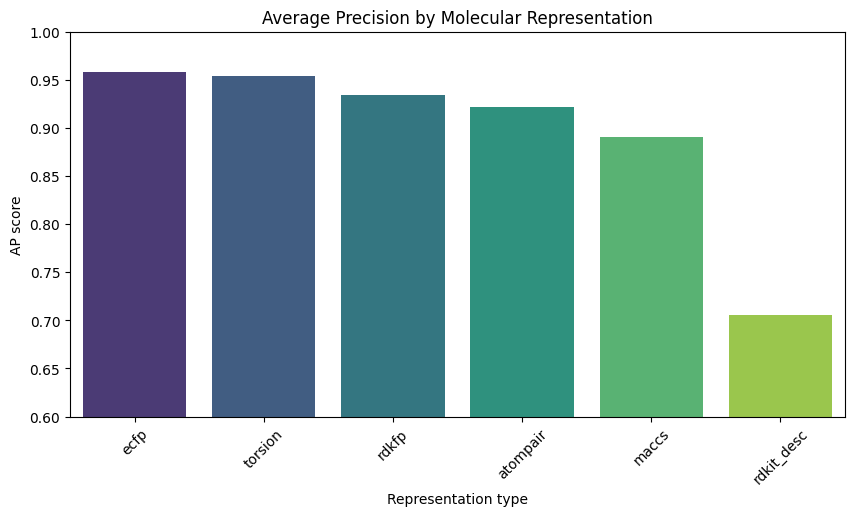

/tmp/ipython-input-2115233577.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="mode", y="ROC_AUC", palette="magma")


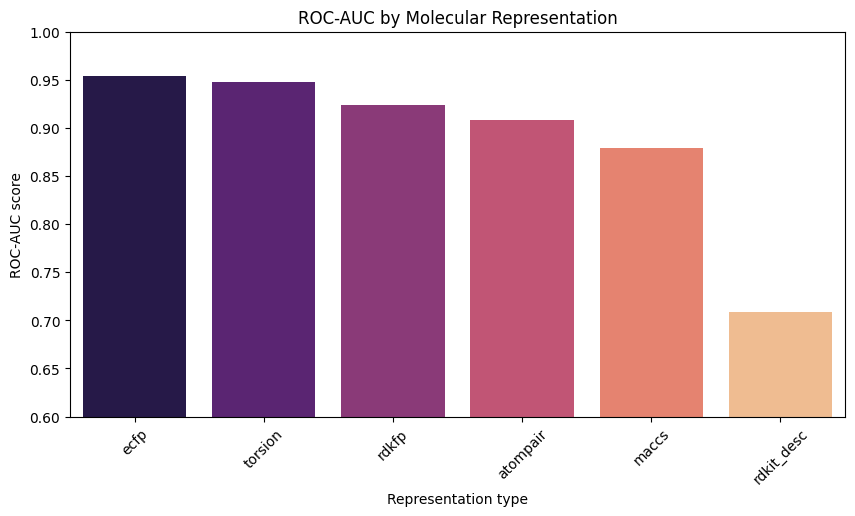

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Якщо results_df ще не відсортований — зробимо
results_df = results_df.sort_values("AP", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="mode", y="AP", palette="viridis")
plt.title("Average Precision by Molecular Representation")
plt.ylabel("AP score")
plt.xlabel("Representation type")
plt.ylim(0.6, 1.0)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="mode", y="ROC_AUC", palette="magma")
plt.title("ROC-AUC by Molecular Representation")
plt.ylabel("ROC-AUC score")
plt.xlabel("Representation type")
plt.ylim(0.6, 1.0)
plt.xticks(rotation=45)
plt.show()


/tmp/ipython-input-2764109521.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=results_df, x="mode", y="AP", palette="viridis")


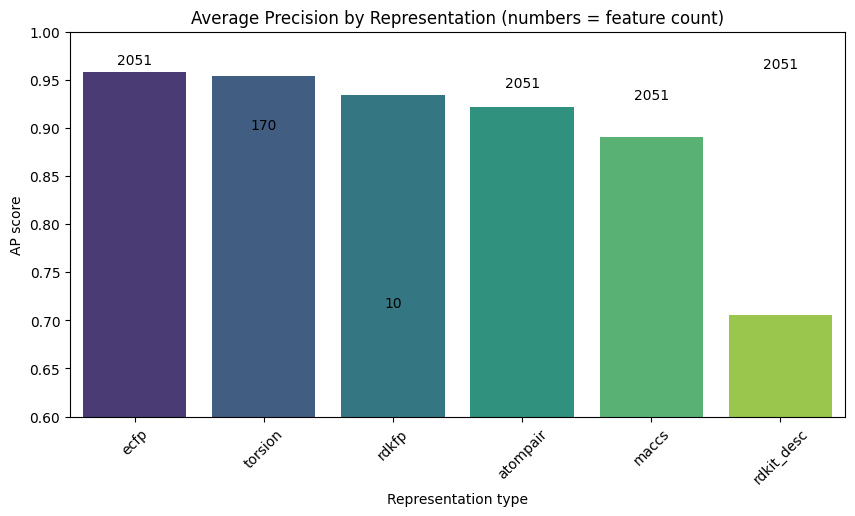

In [39]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=results_df, x="mode", y="AP", palette="viridis")

for i, row in results_df.iterrows():
    ax.text(i, row["AP"] + 0.005, f"{row['n_features']}",
            ha='center', va='bottom', fontsize=10, color="black")

plt.title("Average Precision by Representation (numbers = feature count)")
plt.ylabel("AP score")
plt.xlabel("Representation type")
plt.ylim(0.6, 1.0)
plt.xticks(rotation=45)
plt.show()


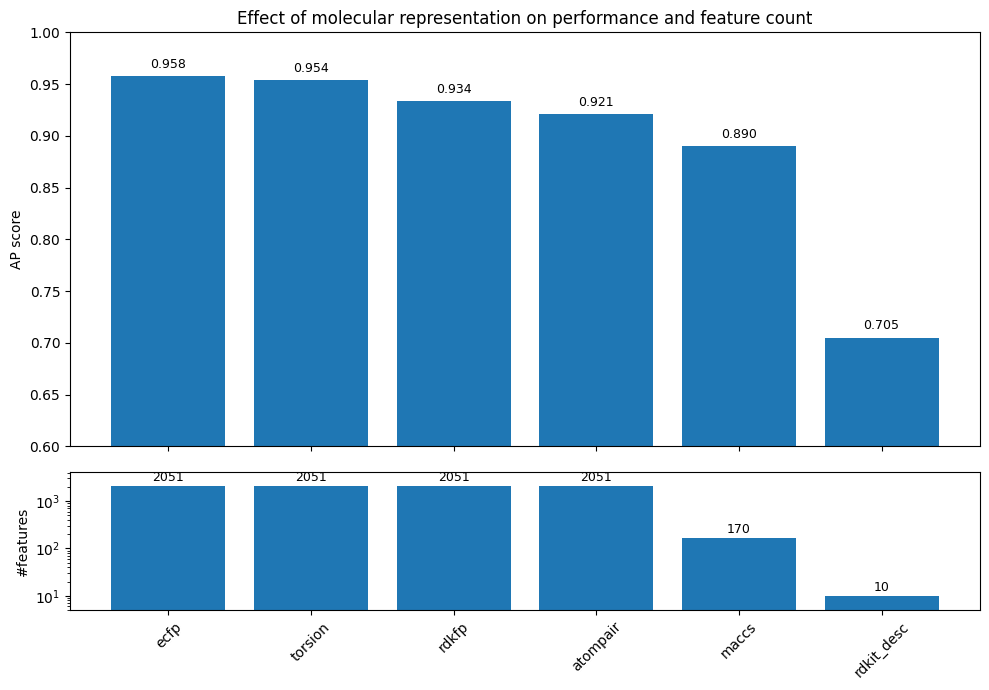

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Переконайся, що results_df відсортований як хочеш (наприклад, за AP)
results_plot = results_df.sort_values("AP", ascending=False).reset_index(drop=True)

modes = results_plot["mode"].tolist()
ap    = results_plot["AP"].to_numpy()
nfeat = results_plot["n_features"].to_numpy()

x = np.arange(len(modes))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True,
                               gridspec_kw={"height_ratios": [3, 1]})

# --- Верхній: AP ---
ax1.bar(x, ap)
ax1.set_ylabel("AP score")
ax1.set_title("Effect of molecular representation on performance and feature count")
ax1.set_ylim(0.6, 1.0)

for i, v in enumerate(ap):
    ax1.text(i, v + 0.005, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

# --- Нижній: кількість фіч ---
ax2.bar(x, nfeat)
ax2.set_ylabel("#features")
ax2.set_xticks(x)
ax2.set_xticklabels(modes, rotation=45)

# (опційно) лог-шкала для фіч, щоб 10 / 170 / 2051 було краще видно
ax2.set_yscale("log")
ax2.set_ylim(5, max(nfeat) * 2)

for i, v in enumerate(nfeat):
    ax2.text(i, v * 1.1, str(int(v)), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
# # --- Imports (можна пропустити, якщо вже є вгорі ноутбука) ---
# from rdkit import Chem
# from rdkit.Chem import AllChem, MACCSkeys, Descriptors, rdMolDescriptors, rdmolops
# from rdkit import DataStructs

# import numpy as np
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import average_precision_score, roc_auc_score

# # Якщо у тебе інші назви колонок – поміняй тут:
# SMILES_COL = "smiles"    # або 'SMILES', 'ligand_smiles', ...
# TARGET_COL = "label"     # або 'binder', 'y', ...

# # --- 1. Допоміжний список дескрипторів RDKit (беремо кілька найтиповіших) ---

# RD_DESC_NAMES = [
#     "MolWt",
#     "MolLogP",
#     "NumHAcceptors",
#     "NumHDonors",
#     "NumRotatableBonds",
#     "RingCount",
#     "TPSA",
# ]

# RD_DESC_FUNCS = [(name, getattr(Descriptors, name)) for name in RD_DESC_NAMES]


# def featurize_smiles(smiles: str, mode: str = "ecfp"):
#     """
#     Перетворює один SMILES у вектор фіч.
#     mode:
#         - 'ecfp'       : Morgan/ECFP fingerprint
#         - 'maccs'      : MACCS keys (166 bits)
#         - 'rdkit_desc' : RDKit physicochemical descriptors
#         - 'rdkfp'      : RDKit topological fingerprint
#         - 'atompair'   : Atom Pair fingerprint
#         - 'torsion'    : Topological Torsion fingerprint
#     Повертає: np.array або None, якщо SMILES не зміг розпарситись.
#     """
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is None:
#         return None

#     # Усі fingerprint-и -> RDKit ExplicitBitVect -> конвертація у numpy
#     if mode == "ecfp":
#         fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
#         arr = np.zeros((2048,), dtype=np.int8)
#         DataStructs.ConvertToNumpyArray(fp, arr)
#         return arr.astype(float)  # RF ок з float

#     elif mode == "maccs":
#         fp = MACCSkeys.GenMACCSKeys(mol)  # 167 bits, але перший біт зазвичай не використовується
#         arr = np.zeros((fp.GetNumBits(),), dtype=np.int8)
#         DataStructs.ConvertToNumpyArray(fp, arr)
#         return arr.astype(float)

#     elif mode == "rdkit_desc":
#         vals = []
#         for name, func in RD_DESC_FUNCS:
#             try:
#                 vals.append(float(func(mol)))
#             except Exception:
#                 vals.append(np.nan)
#         return np.array(vals, dtype=float)

#     elif mode == "rdkfp":
#         fp = rdmolops.RDKFingerprint(mol, fpSize=2048)
#         arr = np.zeros((2048,), dtype=np.int8)
#         DataStructs.ConvertToNumpyArray(fp, arr)
#         return arr.astype(float)

#     elif mode == "atompair":
#         fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=2048)
#         arr = np.zeros((2048,), dtype=np.int8)
#         DataStructs.ConvertToNumpyArray(fp, arr)
#         return arr.astype(float)

#     elif mode == "torsion":
#         fp = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=2048)
#         arr = np.zeros((2048,), dtype=np.int8)
#         DataStructs.ConvertToNumpyArray(fp, arr)
#         return arr.astype(float)

#     else:
#         raise ValueError(f"Unknown mode: {mode}")

# def build_feature_matrix(df, smiles_col: str, target_col: str, mode: str = "ecfp"):
#     """
#     df         : pandas DataFrame з колонками SMILES + label
#     smiles_col : назва колонки з SMILES
#     target_col : назва колонки з таргетом (0/1)
#     mode       : один з варіантів у featurize_smiles()
#     Повертає:
#         X : np.array [n_samples, n_features]
#         y : np.array [n_samples]
#     Викидає рядки, де mol не розпарсився або всі дескриптори NaN.
#     """
#     features = []
#     indices = []

#     for idx, smi in df[smiles_col].items():
#         feat = featurize_smiles(smi, mode=mode)
#         if feat is None:
#             continue
#         # для дескрипторів — пропускаємо, якщо всі NaN
#         if np.all(np.isnan(feat)):
#             continue
#         features.append(feat)
#         indices.append(idx)

#     X = np.vstack(features)
#     y = df.loc[indices, target_col].values
#     return X, y



In [ ]:
for mode in ["ecfp", "maccs", "rdkit_desc", "rdkfp", "atompair", "torsion"]:
    print(f"\n=== Mode: {mode} ===")
    X_train, y_train = build_feature_matrix(train_df, SMILES_COL, TARGET_COL, mode=mode)
    X_valid, y_valid = build_feature_matrix(valid_df, SMILES_COL, TARGET_COL, mode=mode)

    print("Train shape:", X_train.shape, "| Valid shape:", X_valid.shape)

    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        n_jobs=-1,
        class_weight="balanced_subsample",  # можна змінити під свій експеримент
        random_state=42,
    )
    rf.fit(X_train, y_train)

    y_proba = rf.predict_proba(X_valid)[:, 1]
    ap = average_precision_score(y_valid, y_proba)
    roc = roc_auc_score(y_valid, y_proba)

    print(f"Average Precision: {ap:.4f}")
    print(f"ROC-AUC:          {roc:.4f}")